# Trip Duration delivery Prediction : 

## Import libraries : 

In [1]:
import pandas as pd
from sqlalchemy import create_engine
#import pymysql
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from haversine import haversine
import statsmodels.formula.api as sm
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import warnings; warnings.simplefilter('ignore')

## Import Dataset :

In [2]:
task=pd.read_excel("../Clean_Dataset.xlsx")
task["Date"]=pd.to_datetime(task["Date"])
task["realInfoHasPrepared"]=pd.to_datetime(task["realInfoHasPrepared"], format='%Y-%m-%d %H:%M:%S')
task["sourceClosureDate"]=pd.to_datetime(task["sourceClosureDate"], format='%Y-%m-%d %H:%M:%S')

#sort by round Name 
task['sourceSequence'] = task.groupby(['Round_Name','TourneeId']).cumcount().add(1)

# split location Geometry to langitude et latitude: 

task["locationGeometry"]= task["locationGeometry"].map(lambda x: str(x)[1:-1])
local=task["locationGeometry"].tolist()
x_data=[]
y_data=[]

for element in local :
    if element and "," in element:
        x,y = element.split(",")
        x_data.append(float(x))
        y_data.append(float(y))
    else :
        task.drop(task[task['locationGeometry'] == element].index, inplace=True)
#data.drop(['locationGeometry'], axis=1 , inplace=True )
#data.drop(['Code_postal'], axis=1 , inplace=True )
task["pickup_longitude"]=x_data
task["pickup_latitude"]=y_data
task["dropoff_longitude"]= task.pickup_longitude.shift(-1)
task["dropoff_latitude"]= task.pickup_latitude.shift(-1)
     
#data["sourceClosureDate(i-1)"]=data.sourceClosureDate.shift(1)
task.head()

,Date,Round_Name,realInfoHasPrepared,Expediteur,ID_de_la_tache,Type_de_Service,sourceSequence,SourceRealSequence,sourceClosureDate,TaskDurationSec,...,timeWindowStop,TourneeId,TaskId,itemId,vehiculeId,driver_id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,2021-02-25,R63,2021-02-25 05:35:58.813000+00:00,C149,DEL-000330205,LIVRAISON,1,1,2021-02-25 06:47:25.343000+00:00,4287,...,2021-02-25T09:00:00.000Z,603636c63ab20cdd4eb037da,6035ed49da48e783a5a4272d,6035ed49da48e73462a4272f,603638a14e448f8068e8b90c,600eb655b8410bf293e8530c,2.506612,48.812136,2.406808,48.835986
1,2021-02-25,R63,2021-02-25 05:35:58.813000+00:00,C149,DEL-000332033,LIVRAISON,2,2,2021-02-25 07:27:32.410000+00:00,2407,...,2021-02-25T09:00:00.000Z,603636c63ab20cdd4eb037da,603623a8a559e3b5d39b0d98,603623a8a559e311759b0d9a,603638a14e448f8068e8b90c,600eb655b8410bf293e8530c,2.406808,48.835986,2.418641,48.837413
2,2021-02-25,R63,2021-02-25 05:35:58.813000+00:00,C149,DEL-000326209,LIVRAISON,3,3,2021-02-25 07:39:47.322000+00:00,735,...,2021-02-25T09:00:00.000Z,603636c63ab20cdd4eb037da,6035ed4779d70a3f30874242,6035ed4779d70a8891874244,603638a14e448f8068e8b90c,600eb655b8410bf293e8530c,2.418641,48.837413,2.436830,48.851986
3,2021-02-25,R63,2021-02-25 05:35:58.813000+00:00,C149,DEL-000332455,LIVRAISON,4,4,2021-02-25 07:56:09.386000+00:00,982,...,2021-02-25T09:00:00.000Z,603636c63ab20cdd4eb037da,603623ab3bec54467322afa2,603623ab3bec54040b22afa4,603638a14e448f8068e8b90c,600eb655b8410bf293e8530c,2.436830,48.851986,2.447442,48.849543
4,2021-02-25,R63,2021-02-25 05:35:58.813000+00:00,C149,DEL-000331055,LIVRAISON,5,5,2021-02-25 08:07:27.695000+00:00,678,...,2021-02-25T09:00:00.000Z,603636c63ab20cdd4eb037da,6035ed4851429d042982f6fd,6035ed4851429d23d682f6ff,603638a14e448f8068e8b90c,600eb655b8410bf293e8530c,2.447442,48.849543,2.448732,48.867005


## Data Exploration : 

### add new columns to the dataframe :  

In [3]:
data=task.dropna(subset=['sourceClosureDate' ],how='any')
data.drop(['sourceStreet', 'sourceCity', 'sourceCountry','sourceAddress','TaskId',
                'itemId','vehiculeId','driver_id','sourceZip','locationType','Code_postal','ID_de_la_tache','Item___Quantite','Date',
           'SourceRealSequence','timeWindowStop','timeWindowStart'], axis=1 , inplace=True )
data.dropna(inplace=True)

In [4]:
data=data.sort_values(['Round_Name','TourneeId'], ascending=True)
data=data.reset_index(drop=True)

In [222]:
data["realInfoHasPrepared"]=pd.to_datetime(data["realInfoHasPrepared"], format='%Y-%m-%d %H:%M:%S')
data["sourceClosureDate"]=pd.to_datetime(data["sourceClosureDate"], format='%Y-%m-%d %H:%M:%S')
#sort by round Name 
data['sourceSequence'] = data.groupby(['Round_Name','TourneeId']).cumcount().add(1)
data["depart_time"]= data.sourceClosureDate.shift(1)
sourceSequence = data['sourceSequence'].tolist()
depart_time=data["depart_time"].tolist()
realInfoHasPrepared=data["realInfoHasPrepared"].tolist()
for i in range (len(sourceSequence)):
    if sourceSequence[i] == 1 :
        depart_time[i] = realInfoHasPrepared[i]
data["depart_time"] = depart_time

In [5]:
data['month'] = data.realInfoHasPrepared.dt.month
data['weekday_num'] = data.realInfoHasPrepared.dt.weekday
data['pickup_hour'] = data.realInfoHasPrepared.dt.hour
data['weekday'] = data.realInfoHasPrepared.dt.day_name()

In [6]:
def calc_distance(df):
    pickup = (df['pickup_latitude'], df['pickup_longitude'])
    drop = (df['dropoff_latitude'], df['dropoff_longitude'])
    return haversine(pickup, drop)

In [7]:
data['sourceSequence'] = data.groupby(['Round_Name']).cumcount().add(1)
#Calculate distance and assign new column to the dataframe.
data['distance'] = data.apply(lambda x: calc_distance(x), axis = 1)
data['new'] = pd.Series([0 for x in range(len(data.index))])

data.loc[(data.sourceSequence == 1),'new']= 1
data["new"]= data.new.shift(-1)
data.dropna(inplace=True)
data['new'] = data['new'].astype(int)
data.loc[(data.new == 1),'distance']= 0
#Calculate Speed in km/h for further insights
data['speed'] = (data.distance/(data.TaskDurationSec/3600))
data = data[data.distance != 0]
data=data.reset_index(drop=True)

In [226]:
data["latitude_difference"] = data["dropoff_latitude"] - data["pickup_latitude"]
data["longitude_difference"] = data["dropoff_longitude"] - data["pickup_longitude"]

In [8]:
data.drop_duplicates(subset ="locationGeometry",keep = False, inplace = True)

In [9]:
data = data.loc[data["month"] >= 3]

In [10]:
data.drop(['realInfoHasPrepared', 'sourceSequence', 'locationGeometry','sourceHubName',
           'new', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude','dropoff_longitude', 'sourceClosureDate'], axis=1 , inplace=True )

In [154]:
#data.dtypes.reset_index()

In [155]:
#data.TaskDurationSec.groupby(pd.cut(data.TaskDurationSec, np.arange(1,max(data.TaskDurationSec),3600))).count()

In [11]:
data = data[data.TaskDurationSec <= 86400]
data = data[data.TaskDurationSec >= 400]
data["sourceSequence"] = data.groupby(['Round_Name']).cumcount().add(1)
data=data.reset_index(drop=True)
#data.info()

In [12]:
data=data.sort_values("Round_Name", ascending=True)
data=data.reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 935 entries, 0 to 934
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Round_Name                     935 non-null    object 
 1   Expediteur                     935 non-null    object 
 2   Type_de_Service                935 non-null    object 
 3   TaskDurationSec                935 non-null    int64  
 4   Item___Nom_sous_categorie      935 non-null    object 
 5   Item___Type_unite_manutention  935 non-null    object 
 6   sourceZone                     935 non-null    object 
 7   status                         935 non-null    object 
 8   metadataFACTURATION            935 non-null    object 
 9   TourneeId                      935 non-null    object 
 10  month                          935 non-null    int64  
 11  weekday_num                    935 non-null    int64  
 12  pickup_hour                    935 non-null    int

In [ ]:
data

# Data Analysis : 

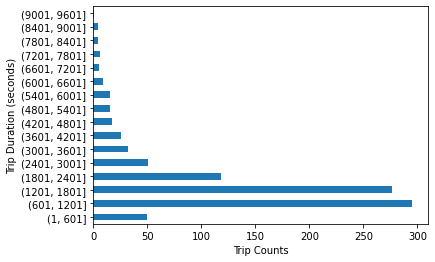

In [159]:
data.TaskDurationSec.groupby(pd.cut(data.TaskDurationSec, np.arange(1,10000,600))).count().plot(kind='barh')
plt.xlabel('Trip Counts')
plt.ylabel('Trip Duration (seconds)')
plt.show()

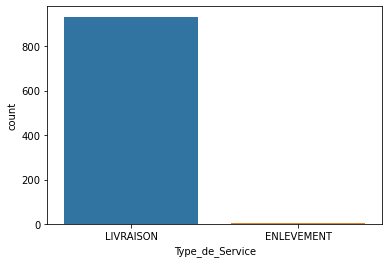

In [160]:
sns.countplot(data.Type_de_Service)
plt.show()

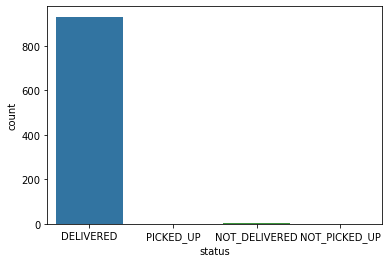

In [161]:
sns.countplot(data.status)
plt.show()

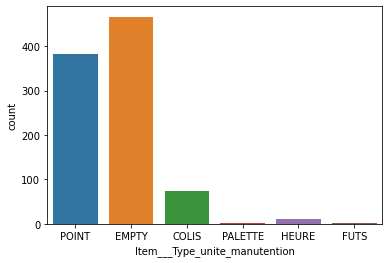

In [162]:
sns.countplot(data.Item___Type_unite_manutention)
plt.show()

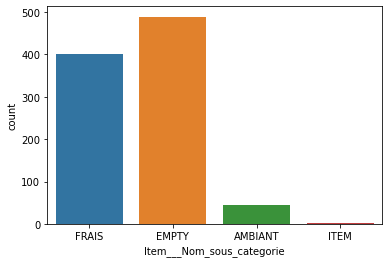

In [163]:
sns.countplot(data.Item___Nom_sous_categorie)
plt.show()

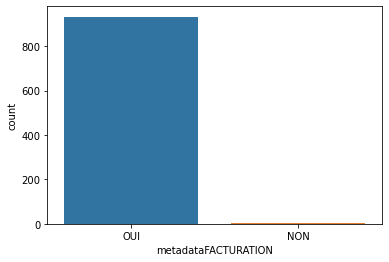

In [164]:
sns.countplot(data.metadataFACTURATION)
plt.show()

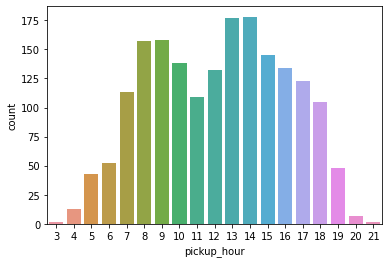

In [64]:
sns.countplot(data.pickup_hour)
plt.show()

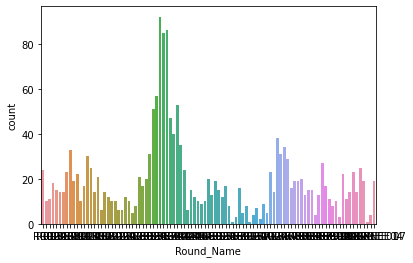

In [65]:
sns.countplot(data.Round_Name)
plt.show()

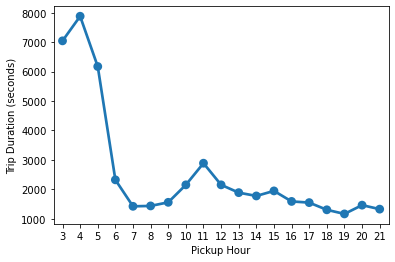

In [66]:
group1 = data.groupby('pickup_hour').TaskDurationSec.mean()
sns.pointplot(group1.index, group1.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Pickup Hour')
plt.show()

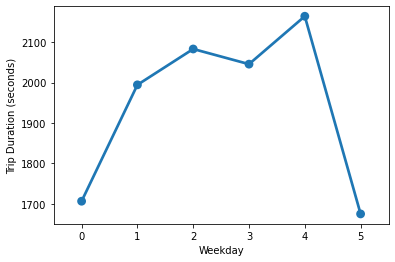

In [67]:
group2 = data.groupby('weekday_num').TaskDurationSec.mean()
sns.pointplot(group2.index, group2.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Weekday')
plt.show()

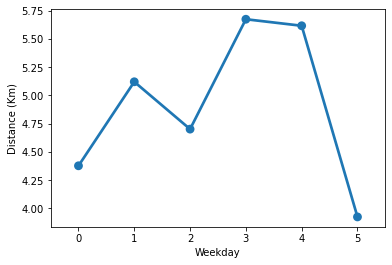

In [68]:
group3 = data.groupby('weekday_num').distance.mean()
sns.pointplot(group3.index, group3.values)
plt.ylabel('Distance (Km)')
plt.xlabel('Weekday')
plt.show()

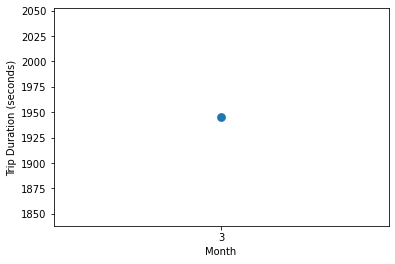

In [69]:
group4 = data.groupby('month').TaskDurationSec.mean()
sns.pointplot(group4.index, group4.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Month')
plt.show()

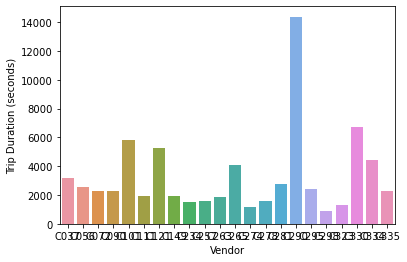

In [70]:
group5 = data.groupby('Expediteur').TaskDurationSec.mean()
sns.barplot(group5.index, group5.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Vendor')
plt.show()

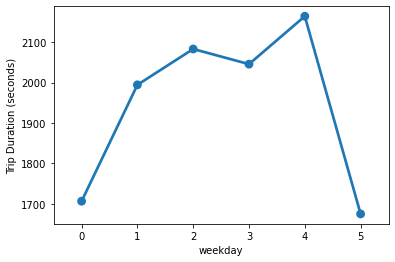

In [71]:
group5 = data.groupby('weekday_num').TaskDurationSec.mean()
sns.pointplot(group5.index, group5.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('weekday')
plt.show()

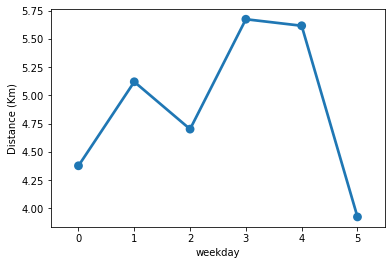

In [72]:
group5 = data.groupby('weekday_num').distance.mean()
sns.pointplot(group5.index, group5.values)
plt.ylabel('Distance (Km)')
plt.xlabel('weekday')
plt.show()

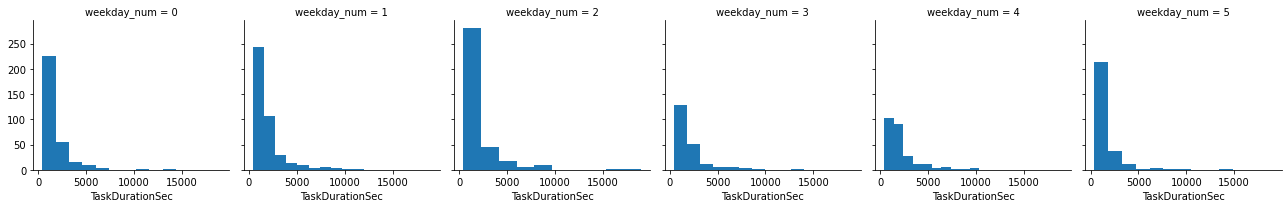

In [73]:
n = sns.FacetGrid(data, col='weekday_num')
n.map(plt.hist, 'TaskDurationSec')
plt.show()

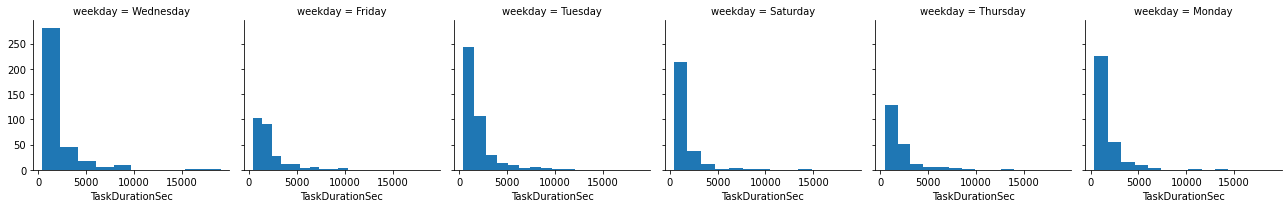

In [74]:
n2 = sns.FacetGrid(data, col='weekday')
n2.map(plt.hist, 'TaskDurationSec')
plt.show()

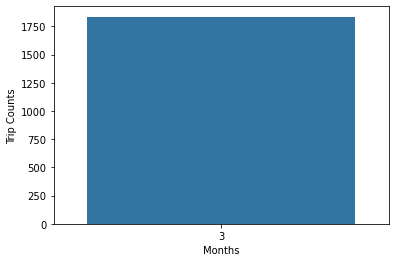

In [75]:
sns.countplot(data.month)
plt.ylabel('Trip Counts')
plt.xlabel('Months')
plt.show()

# Feature Selection :

In [165]:
#First chech the index of the features and label
list(zip( range(0,len(data.columns)),data.columns))

[(0, 'Round_Name'),
 (1, 'Expediteur'),
 (2, 'Type_de_Service'),
 (3, 'TaskDurationSec'),
 (4, 'Item___Nom_sous_categorie'),
 (5, 'Item___Type_unite_manutention'),
 (6, 'sourceZone'),
 (7, 'status'),
 (8, 'metadataFACTURATION'),
 (9, 'TourneeId'),
 (10, 'depart_time'),
 (11, 'month'),
 (12, 'weekday_num'),
 (13, 'pickup_hour'),
 (14, 'weekday'),
 (15, 'distance'),
 (16, 'speed'),
 (17, 'sourceSequence')]

In [166]:
#data.columns

In [13]:
X = data[[ 'Expediteur','pickup_hour','weekday_num','Item___Nom_sous_categorie', 'Item___Type_unite_manutention',
          'sourceZone','distance','speed']]
y = data[["TaskDurationSec"]]
#X = X.iloc[:,:].values
#X.head()


In [14]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_X = LabelEncoder()
for i in range (6):
    X.iloc[:, i:i+1] = labelencoder_X.fit_transform(X.iloc[:, i:i+1])
X=X.reset_index(drop=True)
X

,Expediteur,pickup_hour,weekday_num,Item___Nom_sous_categorie,Item___Type_unite_manutention,sourceZone,distance,speed
0,10,9,2,2,5,20,16.391973,28.562973
1,10,9,2,2,5,20,11.313842,26.937718
2,10,10,2,2,5,6,3.744604,4.765138
3,7,10,2,1,1,0,9.121295,18.111783
4,7,10,2,1,1,11,1.048186,3.621372
...,...,...,...,...,...,...,...,...
930,7,3,0,1,1,18,6.925606,2.221526
931,10,3,0,2,5,14,4.352031,9.199831
932,7,5,2,1,1,19,17.002044,41.496514
933,10,4,2,2,5,6,2.394255,12.941919


In [80]:
X=pd.get_dummies(X, columns=[ 'Expediteur','pickup_hour',
          'sourceZone','weekday_num','Item___Nom_sous_categorie', 'Item___Type_unite_manutention'])
X.head(1)

,distance,speed,Expediteur_0,Expediteur_1,Expediteur_2,Expediteur_3,Expediteur_4,Expediteur_5,Expediteur_6,Expediteur_7,...,Item___Nom_sous_categorie_0,Item___Nom_sous_categorie_1,Item___Nom_sous_categorie_2,Item___Nom_sous_categorie_3,Item___Type_unite_manutention_0,Item___Type_unite_manutention_1,Item___Type_unite_manutention_2,Item___Type_unite_manutention_3,Item___Type_unite_manutention_4,Item___Type_unite_manutention_5
0,3.384038,6.033946,0,0,0,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,0


In [15]:
X = X.iloc[:,:].values
y = y.iloc[:,:].values

In [16]:
print("Let's append {} rows of 1's as the first column in the X array".format(X.shape[0]))

Let's append 935 rows of 1's as the first column in the X array


In [17]:
X1 = np.append(arr = np.ones((X.shape[0],1)).astype(int), values = X, axis = 1)

In [18]:
X1.shape

(935, 9)

In [19]:
y.shape

(935, 1)

In [20]:
import statsmodels.regression.linear_model as sm
#Select all the features in X array
X_opt = X1[:,range(0,9)]
regressor_OLS = sm.OLS(endog = y, exog = X_opt).fit()

#Fetch p values for each feature
p_Vals = regressor_OLS.pvalues

#define significance level for accepting the feature.
sig_Level = 0.05

#Loop to iterate over features and remove the feature with p value less than the sig_level
while max(p_Vals) > sig_Level:
    print("Probability values of each feature \n")
    print(p_Vals)
    X_opt = np.delete(X_opt, np.argmax(p_Vals), axis = 1)
    print("\n")
    print("Feature at index {} is removed \n".format(str(np.argmax(p_Vals))))
    print(str(X_opt.shape[1]-1) + " dimensions remaining now... \n")
    regressor_OLS = sm.OLS(endog = y, exog = X_opt).fit()
    p_Vals = regressor_OLS.pvalues
    print("=================================================================\n")
    
#Print final summary
print("Final stat summary with optimal {} features".format(str(X_opt.shape[1]-1)))
regressor_OLS.summary()

Probability values of each feature 

[4.97635977e-10 8.89568891e-01 8.11223631e-01 8.79586438e-01
 3.37762815e-01 2.79756679e-01 2.74921905e-01 2.49005643e-52
 1.80134222e-59]


Feature at index 1 is removed 

7 dimensions remaining now... 


Probability values of each feature 

[9.02857006e-15 8.05397175e-01 8.83089407e-01 3.37509067e-01
 2.28500511e-01 2.71445230e-01 5.18904517e-53 8.37558732e-60]


Feature at index 2 is removed 

6 dimensions remaining now... 


Probability values of each feature 

[5.42455103e-17 8.29781943e-01 3.37928078e-01 2.24862567e-01
 2.68535399e-01 4.51971148e-53 6.41681239e-60]


Feature at index 1 is removed 

5 dimensions remaining now... 


Probability values of each feature 

[3.79205658e-20 3.39926947e-01 2.08470568e-01 2.51567065e-01
 2.63340232e-53 5.05786029e-60]


Feature at index 1 is removed 

4 dimensions remaining now... 


Probability values of each feature 

[1.73505554e-46 3.59978597e-01 2.25328568e-01 1.11594858e-53
 2.20924797e-60]


Feat

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.271
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     173.3
Date:                Mon, 07 Jun 2021   Prob (F-statistic):           9.90e-65
Time:                        23:38:41   Log-Likelihood:                -8196.4
No. Observations:                 935   AIC:                         1.640e+04
Df Residuals:                     932   BIC:                         1.641e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1948.6022     68.038     28.640      0.000    1815.076    2082.128
x1           226.8008     13.533     16.759      0.000     200.242     253.360
x2           -88.2240      4.987    -17.692      0.000     -98.011     -78.438
==============================================================================
Omnibus:                      748.980   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15301.661
Skew:                           3.595   Prob(JB):                         0.00
Kurtosis:                      21.468   Cond. No.                         26.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Split Data : 

### Splitting the dataset into the Training set and Test set

In [21]:
#Split raw data
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=4, test_size=0.2)

#Split data from the feature selection group
X_train_fs, X_test_fs, y_train_fs, y_test_fs = train_test_split(X_opt,y, random_state=4, test_size=0.2)

## Feature Extraction : 

In [22]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X,y, random_state=4, test_size=0.2)
X_train_pca

array([[ 7.        , 10.        ,  1.        , ..., 19.        ,
         0.50736407,  1.13801287],
       [10.        , 10.        ,  0.        , ...,  8.        ,
         0.2336312 ,  1.13505038],
       [ 7.        , 10.        ,  0.        , ...,  8.        ,
         2.70531644,  7.74792298],
       ...,
       [ 7.        ,  3.        ,  1.        , ...,  4.        ,
         2.15849324, 11.63259828],
       [10.        , 10.        ,  4.        , ..., 20.        ,
        24.62543078, 43.11845856],
       [ 7.        , 10.        ,  4.        , ...,  8.        ,
         3.45176536,  9.9252039 ]])

In [23]:
X_test_pca

array([[10.        ,  7.        ,  2.        , ..., 11.        ,
         5.20046082, 20.21777425],
       [ 7.        , 10.        ,  1.        , ...,  4.        ,
         3.70590558,  5.96390706],
       [ 7.        ,  9.        ,  0.        , ...,  3.        ,
         0.50958248,  1.02029863],
       ...,
       [ 7.        , 11.        ,  5.        , ..., 21.        ,
         2.05350534,  4.69670852],
       [ 7.        ,  8.        ,  5.        , ..., 19.        ,
         9.0588094 , 12.21412504],
       [10.        , 10.        ,  2.        , ...,  7.        ,
         6.51649781, 14.48110625]])

## Scale Data : 

In [24]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_pca = scaler.fit_transform(X_train_pca)
X_test_pca = scaler.transform(X_test_pca)

## PCA application:
Let's apply PCA technique on the training features to understand how many principal 
components should we select for our model to capture atleast 90% variance. For that we will 
take help of plot and cumsum function of numpy package

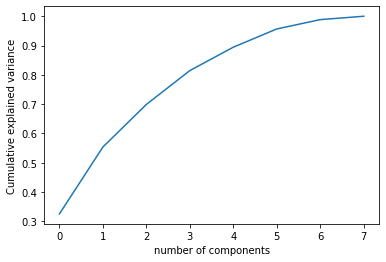

In [25]:
from sklearn.decomposition import PCA
pca = PCA().fit(X_train_pca)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("number of components")
plt.ylabel("Cumulative explained variance")
plt.show()

In [26]:
arr = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
list(zip(range(1,len(arr)), arr))

[(1, 32.51),
 (2, 55.349999999999994),
 (3, 69.89),
 (4, 81.45),
 (5, 89.44),
 (6, 95.66),
 (7, 98.84)]

In [27]:
pca_10 = PCA(n_components=7)
X_train_pca = pca_10.fit_transform(X_train_pca)
X_test_pca = pca_10.transform(X_test_pca)
X_test_pca

array([[-1.70919112,  0.21449094,  0.1002417 , ...,  0.40205508,
        -0.23087581,  0.35498496],
       [ 0.73889217, -0.82522514, -1.44999746, ..., -0.38597367,
         0.04235682, -0.1391573 ],
       [ 0.93585863, -1.5443753 , -1.62465025, ...,  0.10169678,
        -0.14706893,  0.03091188],
       ...,
       [ 0.85759457,  0.08568495,  0.49592277, ..., -2.4428323 ,
         0.94206934,  0.17765268],
       [ 0.90889092,  1.27190591,  0.72248694, ..., -1.5835835 ,
         0.65525284, -0.46699776],
       [-2.01959731, -0.16375375, -0.44293006, ..., -0.1838419 ,
        -0.17961733, -0.06977216]])

## Correlation Analysis :
Correlation analysis is a method of statistical evaluation used to study the strength of a relationship between two or more, numerically measured, continuous variables. This analysis is useful when we need to check if there are possible connections between variables. We will utilize Heatmap for our analysis.

## Heatmap :
A heatmap is a graphical representation of data that uses a system of 
color-coding to represent statistical relationship between different values.
Let's plot the relationship between the features of the Feature selection group first

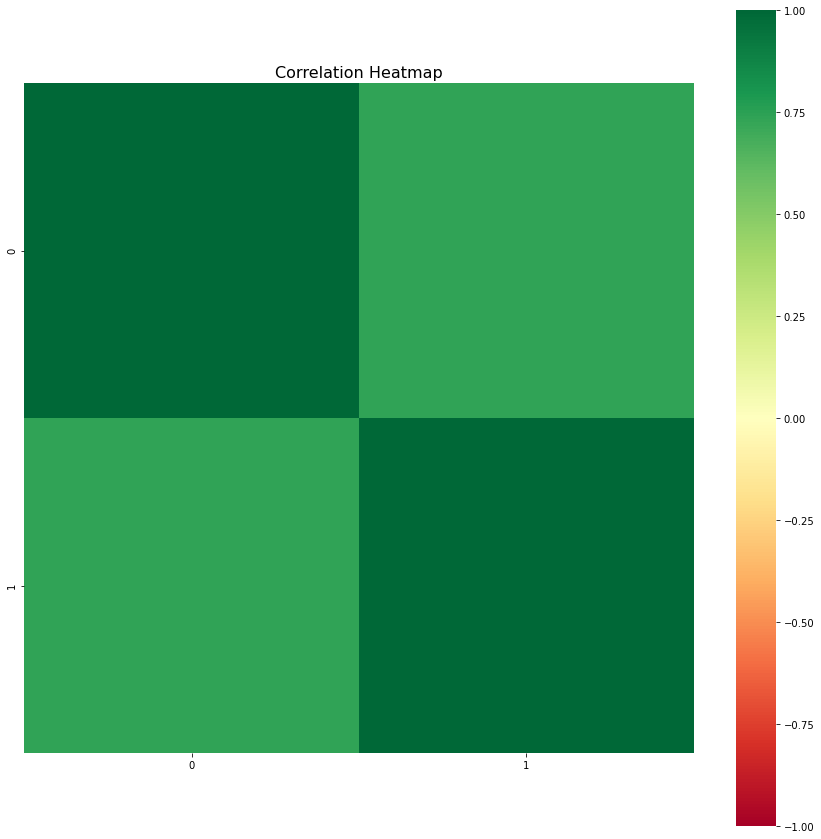

In [28]:
plt.figure(figsize=(15,15))
corr = pd.DataFrame(X_train_fs[:,1:]).corr()
corr.index = pd.DataFrame(X_train_fs[:,1:]).columns
sns.heatmap(corr, cmap='RdYlGn', vmin=-1, vmax=1, square=True)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

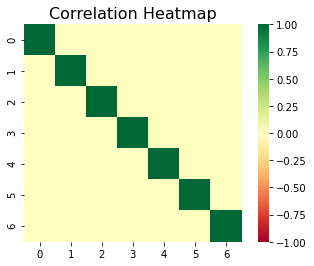

In [29]:
corr = pd.DataFrame(X_train_pca).corr()
corr.index = pd.DataFrame(X_train_pca).columns
sns.heatmap(corr, cmap='RdYlGn', vmin=-1, vmax=1, square=True)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

# Multiple Linear Regression :

## Model training : 

In [30]:
#Linear regressor for the raw data
regressor = LinearRegression() 
regressor.fit(X_train,y_train) 

#Linear regressor for the Feature selection group
regressor1 = LinearRegression() 
regressor1.fit(X_train_fs,y_train_fs) 

#Linear regressor for the Feature extraction group
regressor2 = LinearRegression() 
regressor2.fit(X_train_pca,y_train_pca) 

LinearRegression()

In [31]:
#Predict from the test features of raw data
y_pred = regressor.predict(X_test) 

#Predict from the test features of Feature Selection group
y_pred = regressor1.predict(X_test_fs) 

#Predict from the test features of Feature Extraction group
y_pred_pca = regressor2.predict(X_test_pca) 

In [32]:
#Evaluate the regressor on the raw data
print('RMSE score for the Multiple LR raw is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test,y_pred))))
print('Variance score for the Multiple LR raw is : %.2f' % regressor.score(X_test, y_test))
print("\n")

#Evaluate the regressor on the Feature selection group
print('RMSE score for the Multiple LR FS is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test_fs,y_pred))))
print('Variance score for the Multiple LR FS is : %.2f' % regressor1.score(X_test_fs, y_test_fs))
print("\n")

#Evaluate the regressor on the Feature extraction group
print('RMSE score for the Multiple LR PCA is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test_pca,y_pred_pca))))
print('Variance score for the Multiple LR PCA is : %.2f' % regressor2.score(X_test_pca, y_test_pca))

RMSE score for the Multiple LR raw is : 1729.5355711228835
Variance score for the Multiple LR raw is : 0.32


RMSE score for the Multiple LR FS is : 1729.5355711228835
Variance score for the Multiple LR FS is : 0.32


RMSE score for the Multiple LR PCA is : 1729.7136144526428
Variance score for the Multiple LR PCA is : 0.32


In [251]:
X_train.shape

(748, 8)

In [33]:
#Find linear correlation of each feature with the target variable
from scipy.stats import pearsonr
#df1 = pd.DataFrame(np.concatenate((X_train,y_train.reshape(len(y_train),1)),axis=1))
df1 = pd.DataFrame(np.concatenate((X_train,y_train),axis=1))
df1.columns = df1.columns.astype(str)

features = df1.iloc[:,:8].columns.tolist()
target = df1.iloc[:,8].name

correlations = {}
for f in features:
    data_temp = df1[[f,target]]
    x1 = data_temp[f].values
    x2 = data_temp[target].values
    key = f + ' vs ' + target
    correlations[key] = pearsonr(x1,x2)[0]
    
data_correlations = pd.DataFrame(correlations, index=['Value']).T
data_correlations.loc[data_correlations['Value'].abs().sort_values(ascending=False).index]

,Value
7 vs 8,-0.240506
6 vs 8,0.120204
0 vs 8,-0.064998
5 vs 8,0.049691
4 vs 8,-0.039665
3 vs 8,-0.021725
1 vs 8,-0.011293
2 vs 8,0.005806


In [186]:
y_pred

array([[ 1317.27876921],
       [ 2256.0732664 ],
       [ 1891.76463702],
       [ 4277.1786551 ],
       [ 2021.50202338],
       [ 3072.25667638],
       [ 1508.86640239],
       [ 3525.39768858],
       [ 2157.27596404],
       [ 6455.72817863],
       [ 3283.54208522],
       [ 1477.72628215],
       [ 3393.50674852],
       [ 2149.63512435],
       [ 1145.88218688],
       [ 1647.46239621],
       [ 2019.83368902],
       [ 1855.65554552],
       [ 2822.28249138],
       [ 2201.42053243],
       [ 2260.20934637],
       [ 2593.10251237],
       [  315.56112515],
       [  920.29703367],
       [ 2051.64726577],
       [ 2025.48333367],
       [ 3152.68770766],
       [ 2162.26341319],
       [ 1511.46781818],
       [ 1696.93677714],
       [ 1430.17580533],
       [ 1514.35730524],
       [ 2235.54835772],
       [ 2351.59782625],
       [ 2416.73026193],
       [ 2289.12810841],
       [ 2235.00359032],
       [ 2060.20348091],
       [ 2100.19557676],
       [ 1387.76113932],


### y_pred_pca

In [187]:
y_test_fs

,TaskDurationSec
849,926
47,2237
784,1798
153,6468
138,3075
...,...
630,2561
637,1067
828,1574
886,2670


# Random Forest Regressor :

## Model training : 

In [34]:
#instantiate the object for the Random Forest Regressor with default params from raw data
regressor_rfraw = RandomForestRegressor(n_jobs=-1)

#instantiate the object for the Random Forest Regressor with default params for Feature Selection Group
regressor_rf = RandomForestRegressor(n_jobs=-1)

# #instantiate the object for the Random Forest Regressor with tuned hyper parameters for Feature Selection Group
# regressor_rf1 = RandomForestRegressor(n_estimators = 26,
#                                      max_depth = 22,
#                                      min_samples_split = 9,
#                                      n_jobs=-1)

#instantiate the object for the Random Forest Regressor for Feature Extraction Group
regressor_rf2 = RandomForestRegressor(n_jobs=-1)


#Train the object with default params for raw data
regressor_rfraw.fit(X_train,y_train)

#Train the object with default params for Feature Selection Group
regressor_rf.fit(X_train_fs,y_train_fs)

# #Train the object with tuned params for Feature Selection Group
# regressor_rf1.fit(X_train_fs,y_train_fs)

# #Train the object with default params for Feature Extraction Group
regressor_rf2.fit(X_train_pca,y_train_pca)

print("\n")

## Model prediction :

In [35]:
#Predict the output with object of default params for Feature Selection Group
y_pred_rfraw = regressor_rfraw.predict(X_test)

#Predict the output with object of default params for Feature Selection Group
y_pred_rf = regressor_rf.predict(X_test_fs)

# #Predict the output with object of hyper tuned params for Feature Selection Group
# y_pred_rf1 = regressor_rf1.predict(X_test_fs)

#Predict the output with object of PCA params for Feature Extraction Group
y_pred_rfpca = regressor_rf2.predict(X_test_pca)

print("\n")

In [36]:
#Evaluate the model with default params for raw data
print('RMSE score for the RF regressor raw is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test,y_pred_rfraw))))
print('RMSLE score for the RF regressor raw is : {}'.format(np.sqrt(metrics.mean_squared_log_error(y_test,y_pred_rfraw))))
print('Variance score for the RF regressor raw is : %.2f' % regressor_rfraw.score(X_test, y_test))

print("\n")

#Evaluate the model with default params for Feature Selection Group
print('RMSE score for the RF regressor is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test_fs,y_pred_rf))))
print('RMSLE score for the RF regressor is : {}'.format(np.sqrt(metrics.mean_squared_log_error(y_test_fs,y_pred_rf))))
print('Variance score for the RF regressor is : %.2f' % regressor_rf.score(X_test_fs, y_test_fs))

# print("\n")

# #Evaluate the model with tuned params for Feature Selection Group
# print('RMSE score for the RF regressor1 is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test_fs,y_pred_rf1))))
# print('RMSLE score for the RF regressor1 is : {}'.format(np.sqrt(metrics.mean_squared_log_error(y_test_fs,y_pred_rf1))))
# print('Variance score for the RF regressor1 is : %.2f' % regressor_rf1.score(X_test_fs, y_test_fs))

print("\n")

#Evaluate the model with PCA params  for Feature Extraction Group
print('RMSE score for the RF regressor2 is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test_pca, y_pred_rfpca))))
print('Variance score for the RF regressor2 is : %.2f' % regressor_rf2.score(X_test_pca, y_test_pca))

RMSE score for the RF regressor raw is : 899.6922920587014
RMSLE score for the RF regressor raw is : 0.16918876741466346
Variance score for the RF regressor raw is : 0.82


RMSE score for the RF regressor is : 833.640373322106
RMSLE score for the RF regressor is : 0.14473212918818243
Variance score for the RF regressor is : 0.84


RMSE score for the RF regressor2 is : 1517.7421561750916
Variance score for the RF regressor2 is : 0.48


# XGBoost Regressor :

In [37]:
#instantiate the object for the XGBoost Regressor with default params for raw data
regressor_xgbraw = XGBRegressor(n_jobs=-1)

#instantiate the object for the XGBoost Regressor with default params for Feature Selection Group
regressor_xgb = XGBRegressor(n_jobs=-1)

#instantiate the object for the XGBoost Regressor with tuned hyper parameters for Feature Selection Group
regressor_xgb1 = XGBRegressor(n_estimators=300,
                            learning_rate=0.08,
                            gamma=0,
                            subsample=0.75,
                            colsample_bytree=1,
                            max_depth=7,
                            min_child_weight=4,
                            silent=1,
                           n_jobs=-1)

#instantiate the object for the XGBoost Regressor for Feature Extraction Group
regressor_xgb2 = XGBRegressor(n_jobs=-1)


#Train the object with default params for raw data
regressor_xgbraw.fit(X_train,y_train)

#Train the object with default params for Feature Selection Group
regressor_xgb.fit(X_train_fs,y_train_fs)

#Train the object with tuned params for Feature Selection Group
regressor_xgb1.fit(X_train_fs,y_train_fs)

#Train the object with default params for Feature Extraction Group
regressor_xgb2.fit(X_train_pca,y_train_pca)

print("\n")

[23:39:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.






In [38]:
#Predict the output with object of default params for raw data
y_pred_xgbraw = regressor_xgbraw.predict(X_test)

#Predict the output with object of default params for Feature Selection Group
y_pred_xgb = regressor_xgb.predict(X_test_fs)

#Predict the output with object of hyper tuned params for Feature Selection Group
y_pred_xgb1 = regressor_xgb1.predict(X_test_fs)

#Predict the output with object of PCA params for Feature Extraction Group
y_pred_xgb_pca = regressor_xgb2.predict(X_test_pca)

print("\n")

In [39]:
#Evaluate the model with default params for raw data
print('RMSE score for the XGBoost regressor raw is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test,y_pred_xgbraw))))
# print('RMSLE score for the XGBoost regressor is : {}'.format(np.sqrt(metrics.mean_squared_log_error(y_test,y_pred_xgb))))
print('Variance score for the XGBoost regressor raw is : %.2f' % regressor_xgbraw.score(X_test, y_test))

print("\n")

#Evaluate the model with default params for Feature Selection Group
print('RMSE score for the XGBoost regressor is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test_fs,y_pred_xgb))))
# print('RMSLE score for the XGBoost regressor is : {}'.format(np.sqrt(metrics.mean_squared_log_error(y_test,y_pred_xgb))))
print('Variance score for the XGBoost regressor is : %.2f' % regressor_xgb.score(X_test_fs, y_test_fs))

print("\n")

#Evaluate the model with Tuned params for Feature Selection Group
print('RMSE score for the XGBoost regressor1 is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test_fs,y_pred_xgb1))))
# print('RMSLE score for the XGBoost regressor1 is : {}'.format(np.sqrt(metrics.mean_squared_log_error(y_test_fs,y_pred_xgb1))))
print('Variance score for the XGBoost regressor1 is : %.2f' % regressor_xgb1.score(X_test_fs,y_test_fs))

print("\n")

#Evaluate the model with PCA params  for Feature Extraction Group
print('RMSE score for the XGBoost regressor2 is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test_pca, y_pred_xgb_pca))))
print('Variance score for the XGBoost regressor2 is : %.2f' % regressor_xgb2.score(X_test_pca, y_test_pca))

RMSE score for the XGBoost regressor raw is : 840.568133022036
Variance score for the XGBoost regressor raw is : 0.84


RMSE score for the XGBoost regressor is : 762.6069075922089
Variance score for the XGBoost regressor is : 0.87


RMSE score for the XGBoost regressor1 is : 778.0147693658475
Variance score for the XGBoost regressor1 is : 0.86


RMSE score for the XGBoost regressor2 is : 1546.4575684667393
Variance score for the XGBoost regressor2 is : 0.46


In [40]:
#Comparing test results for the XGBoost and RF regressor
print("Total sum of difference between the actual and the predicted values for the RF regressor is : %d"%np.abs(np.sum(np.subtract(y_test,y_pred_rf))))
print("Total sum of difference between the actual and the predicted values for the tuned XGB regressor is : %d"%np.abs(np.sum(np.subtract(y_test,y_pred_xgb1))))

Total sum of difference between the actual and the predicted values for the RF regressor is : 3316746
Total sum of difference between the actual and the predicted values for the tuned XGB regressor is : 2624057


# Learning curves :

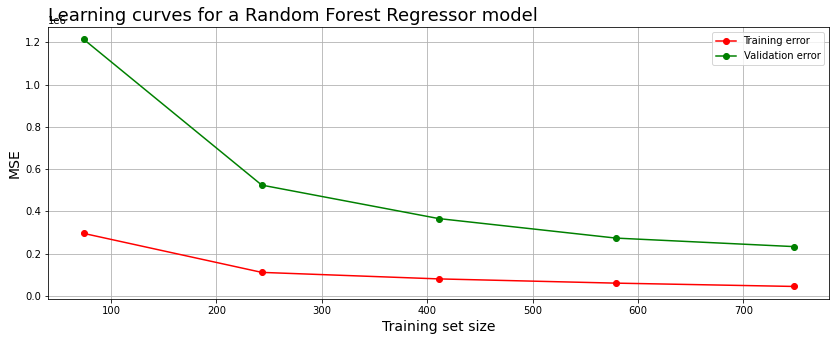

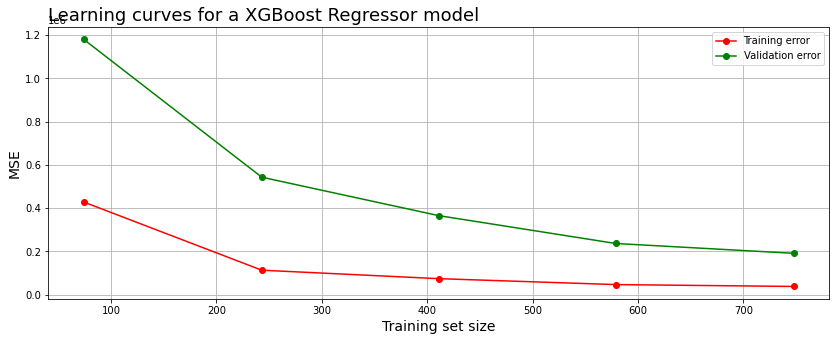

In [41]:
#Define a function to plot learning curve.
def learning_curves(estimator, title, features, target, train_sizes, cv, n_jobs=-1):
    plt.figure(figsize = (14,5))
    train_sizes, train_scores, validation_scores = learning_curve(estimator, features, target, train_sizes = train_sizes, cv = cv, scoring = 'neg_mean_squared_error',  n_jobs=n_jobs)
    train_scores_mean = -train_scores.mean(axis = 1)
    validation_scores_mean = -validation_scores.mean(axis = 1)
    
    plt.grid()
    
    plt.plot(train_sizes, train_scores_mean,'o-', color="r", label = 'Training error')
    plt.plot(train_sizes, validation_scores_mean,'o-', color="g", label = 'Validation error')

    plt.ylabel('MSE', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    
    title = 'Learning curves for a ' + title + ' model'
    plt.title(title, fontsize = 18, loc='left')
    
    plt.legend(loc="best")
    
    return plt

# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=4)

# Plot learning curve for the RF Regressor
title = "Random Forest Regressor"

# Call learning curve with all dataset i.e. traininig and test combined because CV will take of data split.
learning_curves(regressor_rf, title, X_opt,y, train_sizes=np.linspace(.1, 1.0, 5), cv=cv, n_jobs=-1)

#Plot learning curve for the XGBoost Regressor
title = "XGBoost Regressor"

# Call learning curve on less number of estimators than the tuned estimator because it took too much time for the compilation.
learning_curves(XGBRegressor(n_estimators=111,
                            learning_rate=0.08,
                            gamma=0,
                            subsample=0.75,
                            colsample_bytree=1,
                            max_depth=7,
                            min_child_weight=4,
                            silent=1), title, X_opt,y, train_sizes=np.linspace(.1, 1.0, 5), cv=cv, n_jobs=-1)

plt.show()

## Demloy modele pkl : 

In [260]:
import pickle
pickle.dump(regressor_xgb1, open('model_regressor_xgb1.pkl','wb'))

model = pickle.load(open('model_regressor_xgb1.pkl','rb'))

In [261]:
X_train_fs[1]

array([1.        , 0.2336312 , 1.13505038])

In [262]:
y_test_fs

array([[  926],
       [ 2237],
       [ 1798],
       [ 6468],
       [ 3075],
       [ 2594],
       [  829],
       [ 4107],
       [ 1107],
       [ 3427],
       [ 1836],
       [  853],
       [ 4441],
       [  924],
       [ 1015],
       [ 1015],
       [ 1636],
       [  972],
       [ 2324],
       [ 1971],
       [ 1699],
       [ 1620],
       [  807],
       [  646],
       [  738],
       [ 1325],
       [12048],
       [ 5091],
       [ 1103],
       [ 1134],
       [  558],
       [ 1448],
       [  801],
       [  968],
       [ 1982],
       [ 2567],
       [ 1462],
       [ 1021],
       [ 3475],
       [ 1033],
       [ 1682],
       [  626],
       [ 8754],
       [  524],
       [ 1345],
       [  881],
       [ 1062],
       [ 5800],
       [ 1079],
       [  819],
       [ 6267],
       [  641],
       [ 4311],
       [  436],
       [  920],
       [ 1221],
       [  659],
       [ 1478],
       [ 1310],
       [  571],
       [ 2445],
       [ 2446],
       [

In [263]:
df = pd.DataFrame(X_train_fs, 
             columns=['prediction','distance','speed'])
df=df[-187:]
df

,prediction,distance,speed
561,1.0,1.523243,6.281415
562,1.0,3.572327,12.809141
563,1.0,8.946073,15.234562
564,1.0,0.225483,1.268340
565,1.0,2.669576,8.642512
...,...,...,...
743,1.0,13.171242,37.073083
744,1.0,1.649732,4.090244
745,1.0,2.158493,11.632598
746,1.0,24.625431,43.118459


In [264]:
from explainerdashboard import RegressionExplainer

explainer = RegressionExplainer(model, X_test_fs, y_test_fs)

Changing class type to XGBRegressionExplainer...
Generating self.shap_explainer = shap.TreeExplainer(model)


In [265]:
from explainerdashboard import ExplainerDashboard
ExplainerDashboard(explainer).run()

Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
Generating layout...
Calculating shap values...
Calculating predictions...
Calculating residuals...
Calculating absolute residuals...
Generating xgboost model dump...
Calculating dependencies...
Calculating importances...
Calculating shap interaction values...
Reminder: TreeShap computational complexity is O(TLD^2), where T is the number of trees, L is the maximum number of leaves in any tree and D the maximal depth of any tree. So reducing these will speed up the calculation.
Calculating ShadowDecTree for each individual decision tree...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
Starting ExplainerDashboard on http://192.168.1.

 * Running on http://0.0.0.0:8050/ (Press CTRL+C to quit)
192.168.1.20 - - [07/Jun/2021 18:08:25] "GET / HTTP/1.1" 200 -
192.168.1.20 - - [07/Jun/2021 18:08:25] "GET /_dash-dependencies HTTP/1.1" 200 -
192.168.1.20 - - [07/Jun/2021 18:08:25] "GET /_dash-layout HTTP/1.1" 200 -
192.168.1.20 - - [07/Jun/2021 18:08:26] "POST /_dash-update-component HTTP/1.1" 200 -
192.168.1.20 - - [07/Jun/2021 18:08:26] "POST /_dash-update-component HTTP/1.1" 200 -
192.168.1.20 - - [07/Jun/2021 18:08:26] "POST /_dash-update-component HTTP/1.1" 200 -
192.168.1.20 - - [07/Jun/2021 18:08:26] "POST /_dash-update-component HTTP/1.1" 200 -
192.168.1.20 - - [07/Jun/2021 18:08:26] "POST /_dash-update-component HTTP/1.1" 200 -
192.168.1.20 - - [07/Jun/2021 18:08:26] "POST /_dash-update-component HTTP/1.1" 200 -
192.168.1.20 - - [07/Jun/2021 18:08:26] "POST /_dash-update-component HTTP/1.1" 200 -
192.168.1.20 - - [07/Jun/2021 18:08:26] "POST /_dash-update-component HTTP/1.1" 200 -
192.168.1.20 - - [07/Jun/2021 18:08

### Define evaluation metric

In [74]:
import pickle
filename = "xgb_model.sav"
pickle.dump(regressor_xgb, open(filename, 'wb'))

In [77]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
data_dmatrix = xgb.DMatrix(data=X,label=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

[15:51:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


In [78]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 2325.579628


In [79]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

[15:51:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[15:51:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[15:51:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[15:51:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


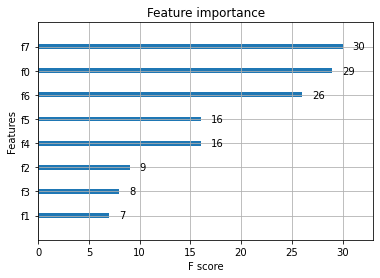

In [81]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()